In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import cv2
import os

In [2]:
tf.random.set_seed(1)
np.random.seed(1)

In [3]:
base_dir = 'D:/Project/capstone/dataset/train'
category_color = ['Biru', 'Coklat', 'Hijau', 'Hitam', 'Jingga', 'Kuning', 'Merah', 'Putih']
img_size = 100

training_data = []
def create_training_data():
    for category in category_color:
        path = os.path.join(base_dir, category)
        class_num = category_color.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img))
                new_array = cv2.resize(img_array, (img_size, img_size))
                training_data.append([new_array, class_num])
            except Exception as e:
                pass
create_training_data()

X = []
y = []

for features, label in training_data:
    X.append(features)
    y.append(label)
X = np.array(X).reshape(-1, img_size, img_size, 3)
X = X / 255.0

In [4]:
df = pd.DataFrame(training_data, columns=['features', 'label'])
df.to_csv('feature_extraction.csv', index=False)
df.to_excel('feature_extraction.xlsx', index=False)

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [6]:
model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), input_shape=(img_size, img_size, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(len(category_color), activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [7]:
from tensorflow.keras.callbacks import EarlyStopping, Callback, ModelCheckpoint

# Membuat sebuah callback untuk menyimpan log pelatihan
class TrainingHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.accuracies = []
        self.val_losses = []  # Tambah ini
        self.val_accuracies = []  # Tambah ini

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.accuracies.append(logs.get('accuracy'))
        self.val_losses.append(logs.get('val_loss'))  # Tambah ini
        self.val_accuracies.append(logs.get('val_accuracy'))  # Tambah ini

history_callback = TrainingHistory()


# Membuat callback untuk menyimpan model terbaik
#checkpoint = ModelCheckpoint('color_classification_model.h5', monitor='val_accuracy', save_best_only=True)
checkpoint = ModelCheckpoint('color_model.h5', monitor='val_accuracy', save_best_only=True)

In [8]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Menambahkan early_stopping ke dalam callbacks
callbacks = [history_callback, checkpoint, early_stopping]

y_train = np.array(y_train)
y_test = np.array(y_test)
model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=callbacks)

Epoch 1/100
4/4 [==============================] - 2s 369ms/step - loss: 8.6742 - accuracy: 0.1157 - val_loss: 5.8802 - val_accuracy: 0.2075
Epoch 2/100
4/4 [==============================] - 1s 287ms/step - loss: 4.9092 - accuracy: 0.3471 - val_loss: 4.9200 - val_accuracy: 0.2264
Epoch 3/100
4/4 [==============================] - 1s 399ms/step - loss: 3.4113 - accuracy: 0.3719 - val_loss: 2.5604 - val_accuracy: 0.4717
Epoch 4/100
4/4 [==============================] - 1s 291ms/step - loss: 1.7057 - accuracy: 0.5207 - val_loss: 1.3785 - val_accuracy: 0.4151
Epoch 5/100
4/4 [==============================] - 1s 350ms/step - loss: 1.1547 - accuracy: 0.5785 - val_loss: 1.0974 - val_accuracy: 0.6604
Epoch 6/100
4/4 [==============================] - 1s 336ms/step - loss: 0.9898 - accuracy: 0.7603 - val_loss: 0.9774 - val_accuracy: 0.7547
Epoch 7/100
4/4 [==============================] - 1s 326ms/step - loss: 0.8402 - accuracy: 0.8182 - val_loss: 0.7513 - val_accuracy: 0.8113
Epoch 8/100
4

In [9]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test accuracy:", test_acc)

2/2 [==============================] - 0s 29ms/step - loss: 0.1795 - accuracy: 0.9057
Test accuracy: 0.9056603908538818


In [10]:
if not os.path.exists("result"):
    os.makedirs("result")

# Menyimpan result ke dalam folder "result"
model.save("result/beda_color_classification_model.h5")

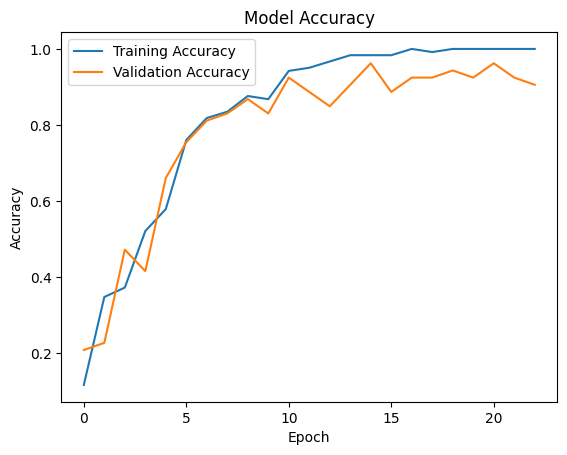

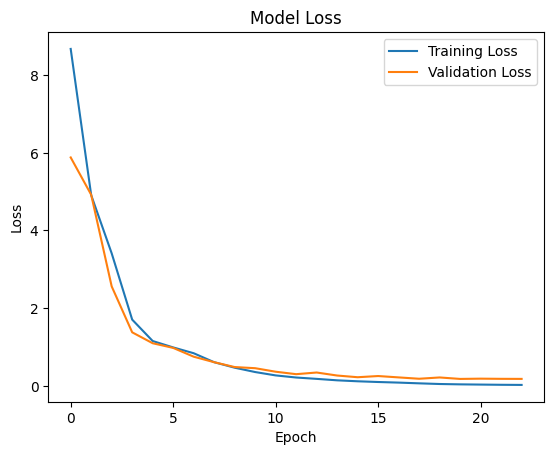

In [11]:
import matplotlib.pyplot as plt

# Menggambar grafik akurasi (training dan validasi)
plt.plot(history_callback.accuracies, label='Training Accuracy')
plt.plot(history_callback.val_accuracies, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.savefig('result/beda_accuracy_plot.png')
plt.show()

# Menggambar grafik loss (training dan validasi)
plt.plot(history_callback.losses, label='Training Loss')
plt.plot(history_callback.val_losses, label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.savefig('result/beda_loss_plot.png')
plt.legend()
plt.show()
